### Respectively plot the local field potentials collected when the mouse is anesthetized under clean background conditions, with respect to four different angles from which the Target 1 cue originates

In [2]:
import sys
import os
import platform

print("Python executable:")
print(sys.executable)
# You're inside an Anaconda virtual environment.

print("\nPlatform:")
print(platform.platform())

print("\nEnvironment:")
if 'conda' in sys.executable.lower() or 'anaconda' in sys.executable.lower():
    print("You're using Anaconda.")
else:
    print("Probably not using Anaconda.")

print("\nCurrent kernel name:")
print(os.environ.get('CONDA_DEFAULT_ENV', 'Not in a Conda environment'))


Python executable:
C:\Users\congy\anaconda3\python.exe

Platform:
Windows-10-10.0.26100-SP0

Environment:
You're using Anaconda.

Current kernel name:
Not in a Conda environment


In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import h5py
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt 
from scipy.signal import spectrogram
from scipy.io import savemat
import scipy.signal as signal
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [4]:
# h5py objects like f['data_combine_Low_downsample'] are lazy readers.
with h5py.File('data\downsampled_LFP.mat', 'r') as f:


    # This loads the entire dataset into memory in one call.
    # [:] → like NumPy slicing, only works for plain numeric datasets
    # [()] → read the entire dataset, including structured or object data
    data = f['data_combine_Low_downsample'][()]
    print(data.shape)
    print(data[:,0])
    
    

(4968346, 32)
[-1.29825076e-05 -1.32193337e-04 -1.92798185e-04 ...  4.27022874e-05
  4.30599057e-05  4.31086802e-05]


In [5]:
def create_notch_filter(fs, f0, Q):
    """
    Create a digital notch filter to remove 60Hz noise
    
    Parameters:
    fs : float
        Sampling frequency in Hz
    f0 : float
        Notch frequency (default 60Hz)
    Q : float
        Quality factor (higher Q = narrower notch)
        
    Returns:
    b, a : ndarray
        Numerator and denominator polynomials of the IIR filter
    """
    # Normalize notch frequency by Nyquist frequency
    w0 = f0/(fs/2)
    
    # Create the notch filter
    b, a = signal.iirnotch(w0, Q)
    
    return b, a

In [6]:
def lowpass_filter(data, fs, cutoff=40, order=6):
    # order: determines how steep the filter is (higher = sharper transition)
    # A low-pass filter passes (keeps) frequencies below the cutoff.
    # It attenuates (reduces) frequencies above the cutoff.
    """

    Apply a low-pass Butterworth filter to the input signal.

    Parameters:
    ----------
    data : array_like
        The input signal data to be filtered.
    fs : float
        The sampling frequency of the signal in Hz.
    cutoff : float, optional
        The cutoff frequency of the filter in Hz. Defaults to 40 Hz.
    order : int, optional
        The order of the Butterworth filter. Higher order means a sharper roll-off. Defaults to 6.

    Returns:
    -------
    filtered_data : ndarray
        The filtered signal, with high frequencies attenuated.
    """

    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    
    # .filtfilt is a function from scipy.signal that applies a zero-phase filter to your data by
    # running the filter forward and then backward.
    return signal.filtfilt(b, a, data)
    

    

In [7]:
sampling_rate = 24414.0625 / 20  # 1220.703125 Hz
b, a = create_notch_filter(sampling_rate, f0=60.0, Q=30)
    
filtered_data = np.zeros_like(data)
sig_data = np.zeros_like(data)
# number of channels 
for ch in range(data.shape[1]):
    # Select all rows (i.e., all time samples) from column ch (i.e., channel ch) of the data array
    notch_applied = signal.lfilter(b, a, data[:, ch])
    filtered_data[:, ch] = lowpass_filter(notch_applied, sampling_rate)

    # Savitzky–Golay filter
    # Savitzky–Golay smoothing is ideal when you want to reduce noise but still retain the original shape of the signal
    # Fits a low-degree polynomial to a sliding window of data points using least squares,
    # and replaces the center point with the predicted value from that polynomial.
    sig_data[:, ch] = savgol_filter(filtered_data[:, ch], window_length=31, polyorder=3)
print(sig_data[:,0])

[-8.59086450e-06 -2.24712599e-05 -3.53881020e-05 ...  1.03051852e-05
  1.69903346e-05  2.44814330e-05]


In [12]:
# h5py objects like f['data_combine_Low_downsample'] are lazy readers.
# with h5py.File(r'C:\Users\congy\Desktop\Gritton_Lab\Katamine_Data\622\downsampled_LFP.mat', 'r') as f:


    # This loads the entire dataset into memory in one call.
    # [:] → like NumPy slicing, only works for plain numeric datasets
    # [()] → read the entire dataset, including structured or object data
    #sig_data = f['data_combine_Low_downsample'][()]
    #print(sig_data.shape)
trial_data = loadmat('data\trial_info.mat')

class Signal:
    #Storing constants and configuration values inside the class, rather than defining them as global variables.
    def __init__(self, sig_data, trial_data, condition, trial_row, trial_column, trial_idx, fs = 24414.0625 / 20):
        self.sig_data = sig_data
        self.trial_data = trial_data
        self.condition = condition
        self.trial_row = trial_row
        self.trial_column = trial_column
        self.trial_idx = trial_idx
        self.fs = fs
        
        
    def slicing_and_concatenate(self):
        trial_info = self.trial_data['trialinfo'][self.trial_row, self.trial_column][self.condition]
        angle_trial_blocks = [trial_info[i][self.trial_idx] for i in range(4)]    # 10 timestamps for each angle; 4 angles 


        return angle_trial_blocks
        
        
    def channel_dict_buildup(self):
        
        four_angle_dict = {}       # key: four angles   value: 10 timestamps for each angle
        angle_trial_blocks = self.slicing_and_concatenate()
   
        for i in range(len(angle_trial_blocks)):

            ch_dict = {}  # dict with key of 32 channels and the corresponding segments on the signal
            trial_timestamps = angle_trial_blocks[i].T 
            for ch in range(self.sig_data.shape[1]):
                channel_data = self.sig_data[:, ch]
                indices = [(int((int(arr)-1)*self.fs), int((int(arr)+4)*self.fs)) for arr in trial_timestamps[0]]
                epoch_segments = [channel_data[start: stop] for (start, stop) in indices]      # 10 items
                ch_dict[ch+1] = epoch_segments
            four_angle_dict[i+1] = ch_dict
        return four_angle_dict
         
    def get_grand_mean_signal(self):

        
        four_angle_dict = self.channel_dict_buildup()
        
        four_mean_signal_dict = {}  # key: four angles    value: grand mean 
        
        mean_signal_sample = {}     #  key: four angles   value: each key has 32 mean signals
        
        for angle in four_angle_dict.keys():  
            mean_signal_sample[angle] = []
            grand_signal = None
            grand_mean_signal =None
            
            for ch_num in four_angle_dict[angle].keys():
                min_length = min(arr.shape[0] for arr in four_angle_dict[angle][ch_num])

                
                trimmed_lst = [arr[:min_length] for arr in four_angle_dict[angle][ch_num]]   # 10 items
                summed_signal = np.sum(trimmed_lst, axis=0)
                mean_signal = summed_signal/len(trimmed_lst)    # 10 times  10 segment in each channel
                # print(mean_signal.shape)
                mean_signal_sample[angle].append(mean_signal)   # each key has 32 mean signals
                if grand_signal is None:
                    grand_signal = np.zeros_like(mean_signal)
                grand_signal += mean_signal                 # 32 times

            if grand_mean_signal is None:
                grand_mean_signal = grand_signal/len(four_angle_dict[angle])   

            four_mean_signal_dict[angle] = grand_mean_signal

        return four_mean_signal_dict, mean_signal_sample
    
    
    def to_get_standard_deviation(self):
        
        std_signal = {}  # dict contain std for each angle (four in total)
        
        
        mean_signal_sample = self.get_grand_mean_signal()[1]
        
        for angle in mean_signal_sample.keys():
            std_signal[angle]=np.std(mean_signal_sample[angle])
        return std_signal
                               
    def plot_grand_mean_signal(self, ylim=(-0.0006,0.0006)):

        
        fig, axes = plt.subplots(4, 1, figsize=(10, 8))
        four_mean_signal_dict = self.get_grand_mean_signal()[0]
        std_signal = self.to_get_standard_deviation()
        
        duration = 5 
        samples = int(duration * self.fs)

        time_axis = np.arange(samples) / self.fs 

   
        
        
        for i,  signal in enumerate(four_mean_signal_dict.values()):

            axes[i].plot(time_axis, signal)
            
            
                    # Plot shaded area for std
            axes[i].fill_between(time_axis,
                                 signal - std_signal[i+1],
                                 signal + std_signal[i+1],
                                 color='gray',
                                 alpha=0.6,
                                 label='±1 STD')
            
            axes[i].set_title('Angle ' + str(i+1))
            axes[i].set_xticks(np.linspace(0, 5, 6))
            axes[i].set_xticklabels(['-1', '0', '1', '2', '3', '4'])
            axes[i].set_xlim(0, 5)
            axes[i].legend()
            axes[i].set_ylim(ylim)
            
        plt.tight_layout()
        plt.show()
        



In [13]:
Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).get_grand_mean_signal()

({1: array([ 5.80120194e-05,  5.73001716e-05,  5.66150499e-05, ...,
         -2.26446615e-05, -2.38315962e-05, -2.46490996e-05]),
  2: array([ 2.44955045e-05,  2.46157256e-05,  2.47703314e-05, ...,
         -3.75789068e-05, -3.97419214e-05, -4.19755885e-05]),
  3: array([ 2.56849469e-05,  2.48491281e-05,  2.35630739e-05, ...,
         -3.96264055e-05, -3.60315695e-05, -3.24388974e-05]),
  4: array([ 3.58775511e-05,  3.52098471e-05,  3.43089284e-05, ...,
         -2.65848370e-06, -1.89962429e-06, -1.21092115e-06])},
 {1: [array([ 2.76878400e-05,  2.68387253e-05,  2.59795467e-05, ...,
          -3.07510928e-05, -3.25746599e-05, -3.40741804e-05]),
   array([ 6.26928610e-05,  6.32797116e-05,  6.40493044e-05, ...,
          -4.86540259e-06, -5.39249978e-06, -5.45609624e-06]),
   array([ 3.41960220e-05,  3.36013314e-05,  3.30000006e-05, ...,
          -7.21973057e-06, -9.03495464e-06, -1.04689505e-05]),
   array([1.31506506e-04, 1.30089105e-04, 1.28658666e-04, ...,
          5.10209196e-06, 

In [73]:
Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).get_grand_mean_signal()[1].shape

(6103,)

In [30]:
Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).to_get_standard_deviation()

{1: 8.841773073960263e-05,
 2: 9.909055934399978e-05,
 3: 9.115939770555462e-05,
 4: 9.021462877674141e-05}

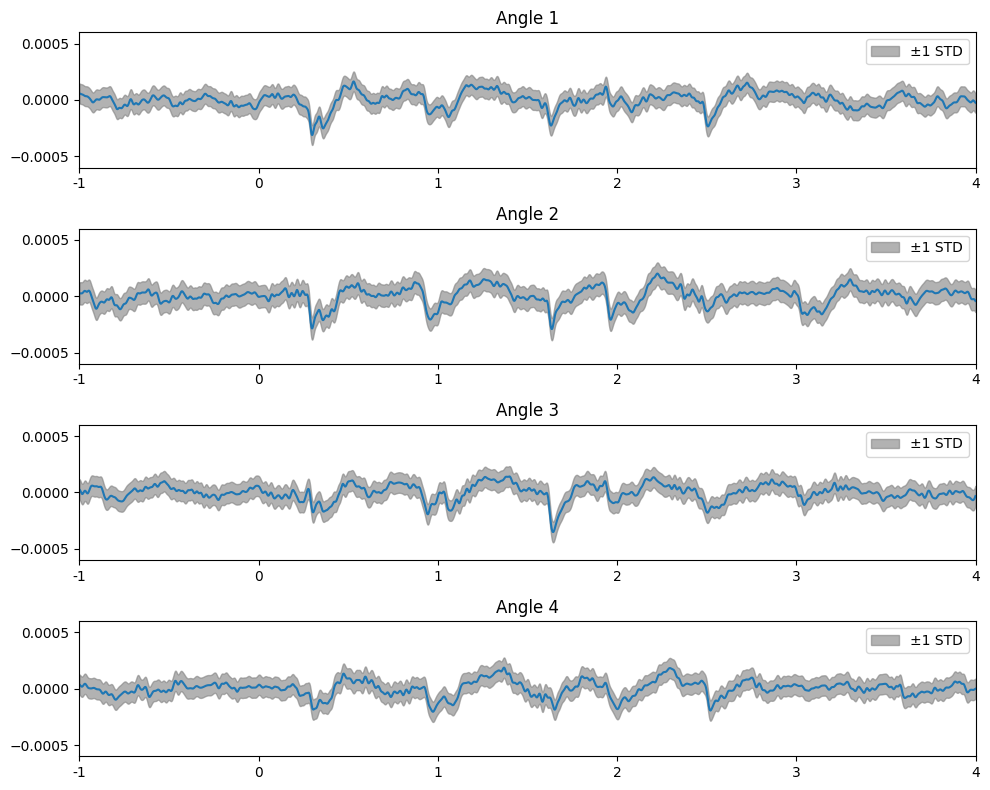

In [39]:
Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).plot_grand_mean_signal()

In [88]:
print(dir(Signal(sig_data, trial_data, 'TSClean', 0, 1, 0)))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'channel_dict_buildup', 'condition', 'fs', 'get_grand_mean_signal', 'plot_grand_mean_signal', 'sig_data', 'slicing_and_concatenate', 'trial_column', 'trial_data', 'trial_idx', 'trial_row']


In [ ]:
#### unfilter signal

In [32]:
Signal(data, trial_data, 'TSClean', 0, 1, 0).to_get_standard_deviation()

{1: 8.984462600239695e-05,
 2: 0.00010772820091585964,
 3: 9.309944954820342e-05,
 4: 9.152436652870829e-05}

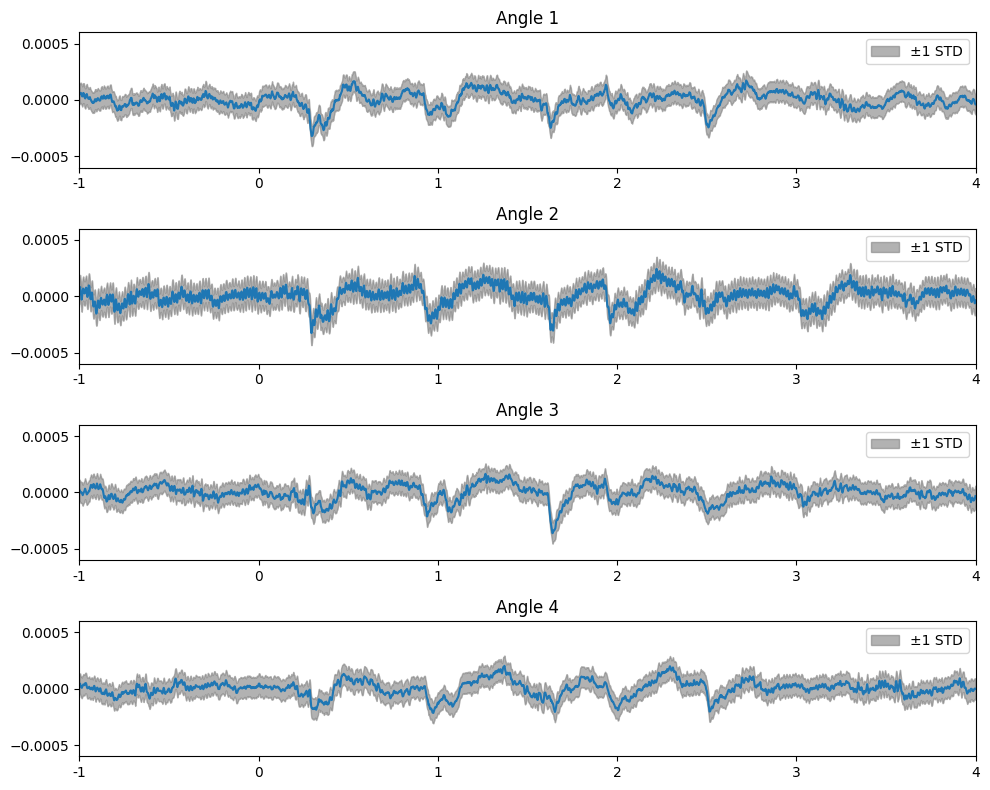

In [41]:
Signal(data, trial_data, 'TSClean', 0, 1, 0).plot_grand_mean_signal()

<br><br>
<span style="font-family:'Times New Roman';font-size:14px">
### Principal Component Analysis


<br>
<span style="font-family:'Times New Roman';">

PCA stands for Principal Component Analysis — it's a powerful mathematical technique used to reduce the dimensionality of data while preserving as much variability (information) as possible.

PCA expects input data of shape:

(n_samples, n_features)
 → You choose what each row represents (a sample), and
 → What each column represents (a feature describing that sample).

 PCA usually reduces the feature dimension, not the sample dimension.
 PCA finds a new set of orthogonal directions (principal components) in feature space and projects
 each sample into a lower-dimensional feature space.

 So:

The number of samples stays the same (n_samples)
The number of features is reduced (n_features → n_components)


🎯 Goal of PCA (in your context):
To reduce high-dimensional neural signals (many timepoints or channels) into 2 or 3 principal components — so you can:

✅ Visualize structure in lower dimensions
You can plot Signal 1 vs Signal 4 and see if they separate in PC space.

✅ Assess separability or similarity
If the two signals form distinct clusters, that suggests they're differentiable (e.g., different stimulus conditions or behaviors).

If they overlap heavily, they might be similar or noisy

</span>
<br><br>

In [ ]:
#### Pre machine learning analysis (Angle 1 vs Angle 4)

In [44]:
four_mean_signal_dict=Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).get_grand_mean_signal()[0]

In [45]:
four_mean_signal_dict

{1: array([ 5.80120194e-05,  5.73001716e-05,  5.66150499e-05, ...,
        -2.26446615e-05, -2.38315962e-05, -2.46490996e-05]),
 2: array([ 2.44955045e-05,  2.46157256e-05,  2.47703314e-05, ...,
        -3.75789068e-05, -3.97419214e-05, -4.19755885e-05]),
 3: array([ 2.56849469e-05,  2.48491281e-05,  2.35630739e-05, ...,
        -3.96264055e-05, -3.60315695e-05, -3.24388974e-05]),
 4: array([ 3.58775511e-05,  3.52098471e-05,  3.43089284e-05, ...,
        -2.65848370e-06, -1.89962429e-06, -1.21092115e-06])}

In [48]:
np.max(four_mean_signal_dict[1])

0.00016414255109720158

In [49]:
np.max(four_mean_signal_dict[4])

0.00018678321564368468

In [57]:
signal_epoch_1 = four_mean_signal_dict[1]
signal_epoch_1.shape


(6103,)

In [56]:
X = signal_epoch_1.T 
X.shape

(6103,)

In [114]:
signal_1_in_total = Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).get_grand_mean_signal()[1][1]
signal_4_in_total = Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).get_grand_mean_signal()[1][4]
print(type(signal_1_in_total))
print(len(signal_1_in_total[0]))
print(type(signal_1_in_total[0]))

<class 'list'>
6103
<class 'numpy.ndarray'>


In [128]:
s1=np.stack(signal_1_in_total)
s1.shape
s4=np.stack(signal_4_in_total)
s4.shape

(32, 6103)

In [130]:
mean_signal_sample = Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).get_grand_mean_signal()[1]
print(len(mean_signal_sample[1]))
print(s1.shape[0])

32
32


In [192]:
four_angle_dict = Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).channel_dict_buildup()

In [193]:
four_angle_dict.keys()

dict_keys([1, 2, 3, 4])

In [194]:
four_angle_dict[1].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [195]:
len(four_angle_dict[1][1])

10


 <br><br><br> 
 <span style="font-family:'Times New Roman';">

### Option 1

 <span style="font-family:'Times New Roman';">
 Goal is to analyze trial-by-trial variation and condition-related dynamics in full spatiotemporal structure.


More channels typically improve discriminability, up to a point — but also add noise and redundancy. So a little overlap at 32 is natural.

#### input -> (10 epoches,  m features)

|Channels	  | Input Shape   |         Separation             |
|-------------|---------------|--------------------------------|
|    1	      |  (10, 6103)    |	            Weak            |
|   10	      |  (10, 61030)   |              Moderate           |
|   20	      | (10, 122060)   |               Strong            |
|   32	      | (10, 195296)   |  Still good but with some<br>overlap due to higher complexity

<br><br>
Plot Feature	                         Meaning
Blue and Orange Dots	         Individual epoch from Signal 1 and Signal 4

Separation in PCA space	         PCA has found that the combined temporal pattern across 32 channels is distinct between the                                    two conditions

Overlap	                         Some shared structure across signals (not completely separable)


This is a clear visualization of how spatiotemporal patterns differ across behaviorally distinct trials

<br><br><br>

6103
(10, 6103)
6103
(10, 6103)
(20, 6103)
(20, 3)
(10, 3)
(10, 3)


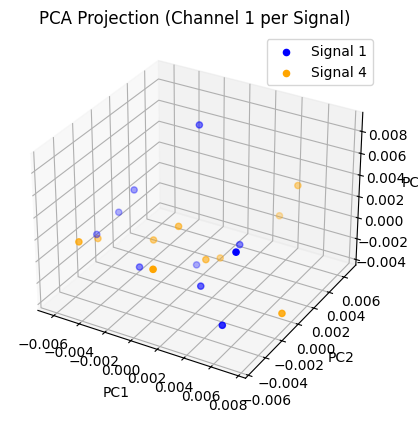

In [70]:
four_angle_dict = Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).channel_dict_buildup()

# Angle 1 on channel 1
min_length = min(epoch.shape[0] for epoch in four_angle_dict[1][1])
print(min_length)
signal_1 = np.array([epoch[:min_length] for epoch in four_angle_dict[1][1]])
print(signal_1.shape)         # (10, 6103)

# angle 4 on channel 1
min_length = min(epoch.shape[0] for epoch in four_angle_dict[4][1])
print(min_length)
signal_4 = np.array([epoch[:min_length] for epoch in four_angle_dict[4][1]])
print(signal_4.shape)       # (10, 6103)  
    



# PCA expects input data of shape:
# (n_samples, n_features)
# → You choose what each row represents (a sample), and
# → What each column represents (a feature describing that sample).

# PCA usually reduces the feature dimension, not the sample dimension.
# PCA finds a new set of orthogonal directions (principal components) in feature space and projects
# each sample into a lower-dimensional feature space.

# So:

# The number of samples stays the same (n_samples)
# The number of features is reduced (n_features → n_components)


# Fit PCA on combined data (recommended)
X_combined = np.vstack([signal_1, signal_4])
print(X_combined.shape)
pca = PCA(n_components=3)
X_combined_reduced = pca.fit_transform(X_combined)     # shape: (20, 3)

print(X_combined_reduced.shape)


# Split back
X1_reduced = X_combined_reduced[:10]     # Takes the first 10 rows (index 0 to 9)  Slicing syntax like [:10] applies to rows by default
X4_reduced = X_combined_reduced[10:]

print(X1_reduced.shape)
print(X4_reduced.shape)

# 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*X1_reduced.T, color='blue', label='Signal 1', s=20)
ax.scatter(*X4_reduced.T, color='orange', label='Signal 4', s=20)

ax.set_title("PCA Projection (Channel 1 per Signal)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()



6103
(10, 61030)
6103
(10, 61030)
(20, 61030)
(20, 3)
(10, 3)
(10, 3)


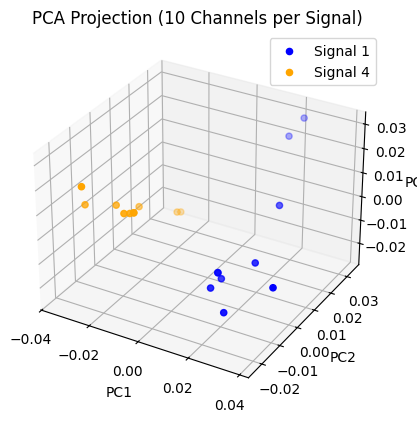

In [13]:
four_angle_dict = Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).channel_dict_buildup()

# Angle 1 on channel 1
min_length = min(epoch.shape[0] for i in range(1,11) for epoch in four_angle_dict[1][i])
print(min_length)
signal_1 = np.array([epoch[:min_length] for i in range(1,11) for epoch in four_angle_dict[1][i]])
signal_1 = signal_1.reshape(10, -1)
print(signal_1.shape)

# angle 4 on channel 1

# i is defined before it's used in four_angle_dict[1][i]
min_length = min(epoch.shape[0] for i in range(1, 11) for epoch in four_angle_dict[4][i])
print(min_length)
signal_4 = np.array([epoch[:min_length] for i in range(1, 11) for epoch in four_angle_dict[4][i]])
signal_4 = signal_4.reshape(10, -1)
print(signal_4.shape)
    


# Fit PCA on combined data (recommended)
X_combined = np.vstack([signal_1, signal_4])
print(X_combined.shape)
pca = PCA(n_components=3)
X_combined_reduced = pca.fit_transform(X_combined)

print(X_combined_reduced.shape)


# Split back
X1_reduced = X_combined_reduced[:10]
X4_reduced = X_combined_reduced[10:]

print(X1_reduced.shape)
print(X4_reduced.shape)

# 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*X1_reduced.T, color='blue', label='Signal 1', s=20)
ax.scatter(*X4_reduced.T, color='orange', label='Signal 4', s=20)

ax.set_title("PCA Projection (10 Channels per Signal)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()


6103
(10, 122060)
6103
(10, 122060)
(20, 122060)
(20, 3)
(10, 3)
(10, 3)


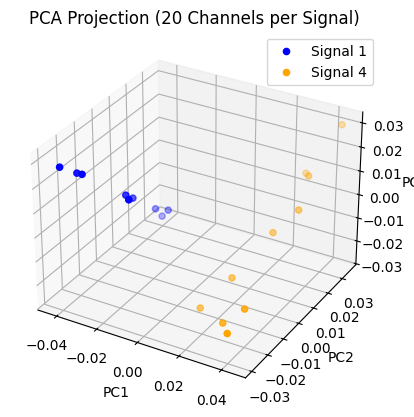

In [14]:
four_angle_dict = Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).channel_dict_buildup()

# Angle 1 on 20 channels 
min_length = min(epoch.shape[0]  for i in range(1, 21) for epoch in four_angle_dict[1][i])
print(min_length)
signal_1 = np.array([epoch[:min_length] for i in range(1, 21) for epoch in four_angle_dict[1][i]])
signal_1 = signal_1.reshape(10, -1)
print(signal_1.shape)

# # angle 2 on 20 channels
# min_length = min(epoch.shape[0] for i in range(1, 21) for epoch in four_angle_dict[2][i])
# print(min_length)
# signal_2 = np.array([epoch[:min_length]for i in range(1, 21) for epoch in four_angle_dict[2][i]])
# signal_2 = signal_2.reshape(10, -1)
# print(signal_2.shape)

# angle 4 on 20 channels
min_length = min(epoch.shape[0] for i in range(1, 21) for epoch in four_angle_dict[4][i])
print(min_length)
signal_4 = np.array([epoch[:min_length]for i in range(1, 21) for epoch in four_angle_dict[4][i]])
signal_4 = signal_4.reshape(10, -1)
print(signal_4.shape)
    
# X1 = signal_1.T
# print(X1.shape) 
# X4 = signal_4.T    
# print(X4.shape) 

# Fit PCA on combined data (recommended)
X_combined = np.vstack([signal_1, signal_4])
print(X_combined.shape)
pca = PCA(n_components=3)
X_combined_reduced = pca.fit_transform(X_combined)

print(X_combined_reduced.shape)


# Split back
X1_reduced = X_combined_reduced[:10]
# X2_reduced = X_combined_reduced[10:20]
X4_reduced = X_combined_reduced[10:]

print(X1_reduced.shape)
print(X4_reduced.shape)

# 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*X1_reduced.T, color='blue', label='Signal 1', s=20)
# ax.scatter(*X2_reduced.T, color='green', label='Signal 2', s=20)
ax.scatter(*X4_reduced.T, color='orange', label='Signal 4', s=20)

ax.set_title("PCA Projection (20 Channels per Signal)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()

6103
(10, 195296)
6103
[[-3.25792861e-05 -3.40952405e-05 -3.55652301e-05 ... -2.48108577e-05
  -2.38722722e-05 -2.29246814e-05]
 [-3.67180792e-05 -3.87942138e-05 -4.07703572e-05 ... -5.91076830e-05
  -5.74913155e-05 -5.58011517e-05]
 [-6.48449645e-05 -6.71039794e-05 -6.94856672e-05 ... -6.90657835e-05
  -6.99805101e-05 -7.05061803e-05]
 ...
 [-4.39106045e-05 -4.38024314e-05 -4.36138432e-05 ...  2.50623674e-05
   2.49412052e-05  2.48605129e-05]
 [ 4.26415107e-05  4.15715280e-05  4.02891356e-05 ... -6.46874814e-05
  -6.36701591e-05 -6.27132453e-05]
 [ 3.12644519e-05  3.14186402e-05  3.15975175e-05 ...  2.94785407e-06
   2.39076825e-06  1.86011142e-06]]
[[-3.25792861e-05 -3.40952405e-05 -3.55652301e-05 ...  1.19874748e-04
   1.25228528e-04  1.30772188e-04]
 [ 2.57266359e-04  2.55905240e-04  2.54476979e-04 ...  5.39582873e-05
   5.11690463e-05  4.79468128e-05]
 [ 6.64552840e-05  6.33553615e-05  5.98790077e-05 ... -2.09669764e-04
  -2.06835166e-04 -2.03953157e-04]
 ...
 [-7.06160381e-05 -7.

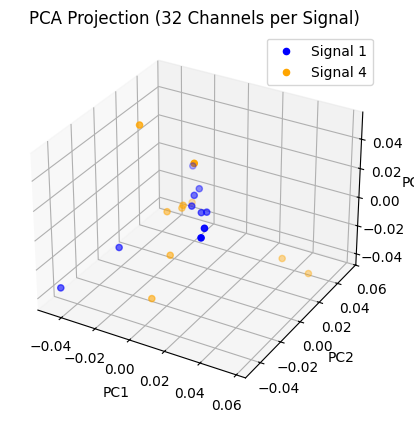

In [15]:
four_angle_dict = Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).channel_dict_buildup()

# Angle 1 on 32 channels
min_length = min(epoch.shape[0] for i in range(1, 33) for epoch in four_angle_dict[1][i])
print(min_length)
signal_1 = np.array([epoch[:min_length] for i in range(1, 33) for epoch in four_angle_dict[1][i]])
signal_1 = signal_1.reshape(10, -1)
print(signal_1.shape)




# angle 4 on 32 channels 
min_length = min(epoch.shape[0] for i in range(1, 33) for epoch in four_angle_dict[4][i])
print(min_length)
signal_4 = np.array([epoch[:min_length] for i in range(1, 33) for epoch in four_angle_dict[4][i]])
print(signal_4)
signal_4 = signal_4.reshape(10, -1)

print(signal_4)
print(signal_4.shape)
    
# X1 = signal_1.T
# print(X1.shape) 
# X4 = signal_4.T    
# print(X4.shape) 

# Fit PCA on combined data (recommended)
X_combined = np.vstack([signal_1, signal_4])
print(X_combined.shape)
pca = PCA(n_components=3)
X_combined_reduced = pca.fit_transform(X_combined)

print(X_combined_reduced.shape)


# Split back
X1_reduced = X_combined_reduced[:10]
X4_reduced = X_combined_reduced[10:]

print(X1_reduced.shape)
print(X4_reduced.shape)

# 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*X1_reduced.T, color='blue', label='Signal 1', s=20)
ax.scatter(*X4_reduced.T, color='orange', label='Signal 4', s=20)

ax.set_title("PCA Projection (32 Channels per Signal)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()

<br><br>
##### Method 2 for Option 1

In [80]:
class PCA_option_1:
    
    def __init__(self, four_angle_dict, arbi_angle_1, arbi_angle_2, num_channels):
        self.four_angle_dict = four_angle_dict
        self.angle_1 = arbi_angle_1
        self.angle_2 = arbi_angle_2
        self.number_channels = num_channels 
        
    def to_get_signal_for_specific_angle(self):
        

        # Angle 1 
        min_length_1 = min(epoch.shape[0] for i in range(1, self.number_channels+1) for epoch in self.four_angle_dict[self.angle_1][i])
   
        signal_1 = np.array([epoch[:min_length_1] for i in range(1, self.number_channels+1) for epoch in self.four_angle_dict[self.angle_1][i]])
        signal_1 = signal_1.reshape(10, -1)
  

        # Angle 2
        min_length_2 = min(epoch.shape[0] for i in range(1, self.number_channels+1) for epoch in self.four_angle_dict[self.angle_2][i])
 
        signal_2 = np.array([epoch[:min_length_2] for i in range(1, self.number_channels+1) for epoch in self.four_angle_dict[self.angle_2][i]])
        signal_2 = signal_2.reshape(10, -1)
 
        return signal_1, signal_2



    def to_fit_PCA_on_combined_data_and_split(self):
        
        signal_1, signal_2 = self.to_get_signal_for_specific_angle()
        # Fit PCA on combined data (recommended)
        X_combined = np.vstack([signal_1, signal_2])
        #print(X_combined.shape)
        pca = PCA(n_components=3)
        X_combined_reduced = pca.fit_transform(X_combined)

        #print(X_combined_reduced.shape)


        # Split back
        X1_reduced = X_combined_reduced[:10]
        X2_reduced = X_combined_reduced[10:]

        #print(X1_reduced.shape)
        #print(X2_reduced.shape)
        return X1_reduced, X2_reduced, X_combined_reduced
        
    def to_plot_3D_scatter(self):
        
        X1_reduced, X2_reduced = self.to_fit_PCA_on_combined_data_and_split()[:2]
        # 3D scatter plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(*X1_reduced.T, color='blue', label='angle '+ str(self.angle_1), s=20)
        ax.scatter(*X2_reduced.T, color='orange', label='angle '+str(self.angle_2), s=20)

        ax.set_title(f"PCA Projection ({self.number_channels} Channels per Signal)")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.legend()
        plt.show()
        
        
    def to_apply_KMean(self):
        # Apply K-means clustering
        X1_reduced, X2_reduced, X_combined_reduced = self.to_fit_PCA_on_combined_data_and_split()
        
        # Creates a KMeans object from scikit-learn.
        # n_clusters=2`: You want to find 2 clusters (corresponding to your 2 angles).
        # n_init=10`: The algorithm will run 10 times with different centroid seeds and return the best result.
        # random_state=0`: Ensures reproducibility (same clustering every time you run the code)
        kmeans = KMeans(n_clusters=2, n_init=10,random_state=0)
        
        # fit_predict() is a shorthand that:
        # Fits the KMeans model to the data (i.e., finds centroids).
        # Predicts the cluster label (either 0 or 1 in your case) for each sample.
        # The result labels is a NumPy array of length equal to the number of data points, assigning each point to one of the 2 clusters.
        labels = kmeans.fit_predict(X_combined_reduced)
        #print(labels)
        # Optional: true labels (for visual comparison only, not used by K-means)
        true_labels = np.array([0]*len(X1_reduced) + [1]*len(X2_reduced))
        


        acc_1 = accuracy_score(true_labels, labels)
        acc_2 = accuracy_score(true_labels, 1 - labels)  # flip 0↔1
        accuracy = max(acc_1, acc_2)
        #print(f"K-means Accuracy: {accuracy:.2f}")
        
        return accuracy,labels 

    def to_plot_KMean(self):
        _, _, X_combined_reduced = self.to_fit_PCA_on_combined_data_and_split()
        _,labels = self.to_apply_KMean()
        # Plot in 3D
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        # alpha=0.8 makes points semi-transparent
        ax.scatter(X_combined_reduced[:, 0], X_combined_reduced[:, 1], X_combined_reduced[:, 2], c=labels, cmap='coolwarm', alpha=0.8)
        ax.set_title(f"K-means Clustering in {self.number_channels} channels")
        plt.show()
        

        

        

In [52]:
four_angle_dict = Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).channel_dict_buildup()

(20, 6103)
(20, 3)
(10, 3)
(10, 3)


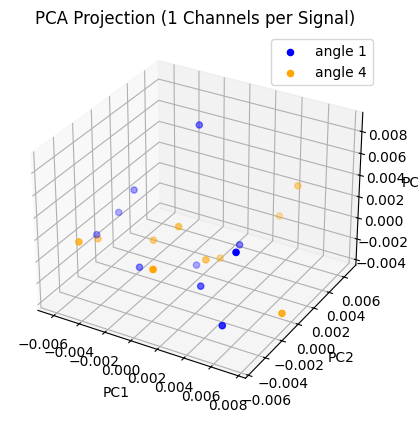

In [18]:
PCA_option_1(four_angle_dict, 1, 4, 1).to_plot_3D_scatter()

(20, 6103)
(20, 3)
(10, 3)
(10, 3)
(20, 6103)
(20, 3)
(10, 3)
(10, 3)
[1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1]
K-means Accuracy: 0.50


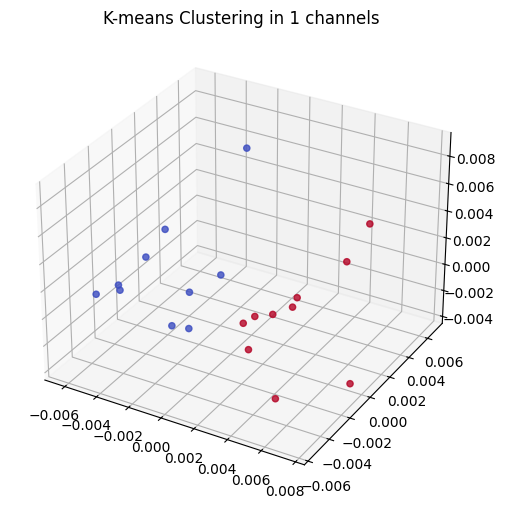

In [62]:
PCA_option_1(four_angle_dict, 1, 4, 1).to_plot_KMean()

(20, 61030)
(20, 3)
(10, 3)
(10, 3)


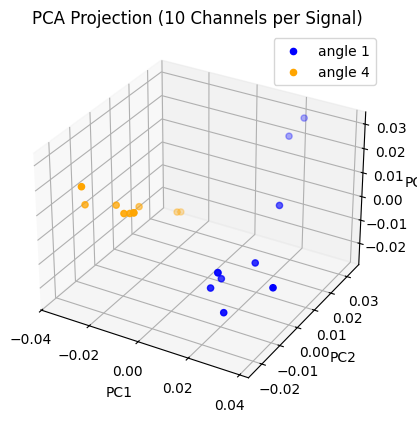

In [20]:
PCA_option_1(four_angle_dict, 1, 4, 10).to_plot_3D_scatter()

(20, 61030)
(20, 3)
(10, 3)
(10, 3)
(20, 61030)
(20, 3)
(10, 3)
(10, 3)
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
K-means Accuracy: 1.00


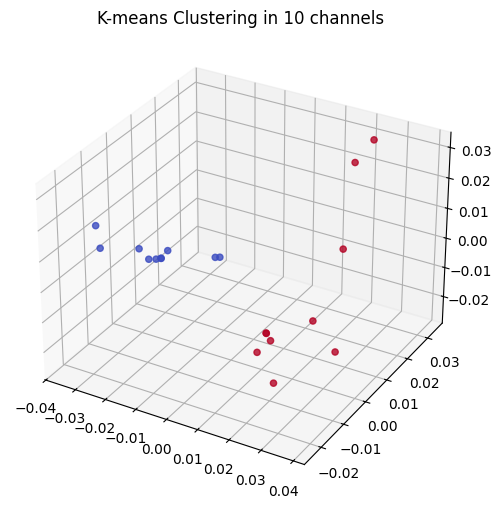

In [63]:
PCA_option_1(four_angle_dict, 1, 4, 10).to_plot_KMean()

(20, 122060)
(20, 3)
(10, 3)
(10, 3)


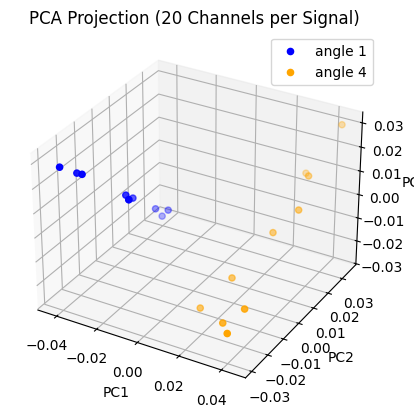

In [40]:
PCA_option_1(four_angle_dict, 1, 4, 20).to_plot_3D_scatter()

(20, 122060)
(20, 3)
(10, 3)
(10, 3)
(20, 122060)
(20, 3)
(10, 3)
(10, 3)
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
K-means Accuracy: 1.00


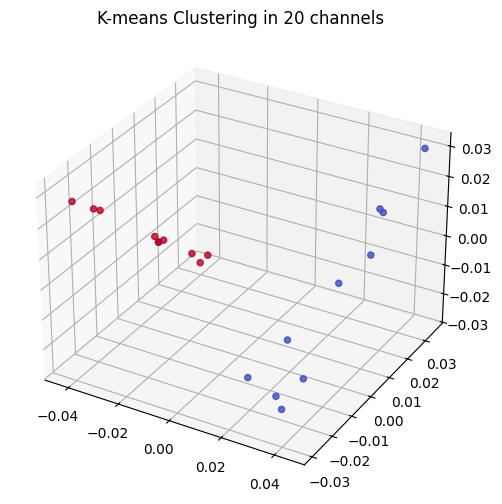

In [64]:
PCA_option_1(four_angle_dict, 1, 4, 20).to_plot_KMean()

(20, 195296)
(20, 3)
(10, 3)
(10, 3)


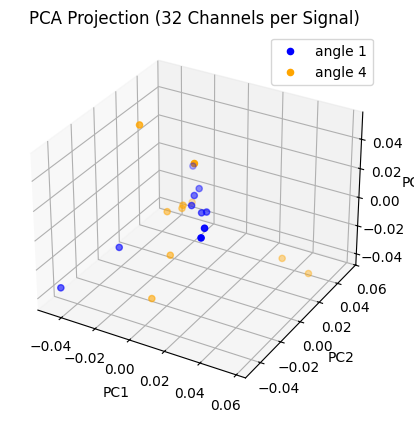

In [37]:
PCA_option_1(four_angle_dict, 1, 4, 32).to_plot_3D_scatter()

(20, 195296)
(20, 3)
(10, 3)
(10, 3)
(20, 195296)
(20, 3)
(10, 3)
(10, 3)
[0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0]
K-means Accuracy: 0.50


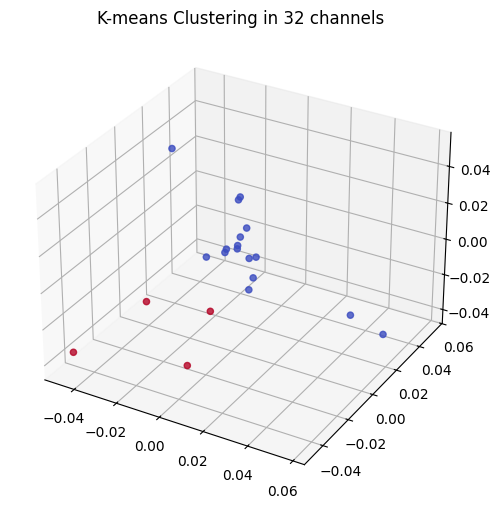

In [65]:
PCA_option_1(four_angle_dict, 1, 4, 32).to_plot_KMean()

[0.5, 0.6, 0.55, 0.5, 0.75, 0.65, 0.55, 0.55, 0.55, 1.0, 0.55, 0.5, 0.55, 0.55, 0.75, 0.6, 0.55, 0.6, 0.55, 1.0, 0.55, 0.6, 0.55, 0.6, 0.75, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5]


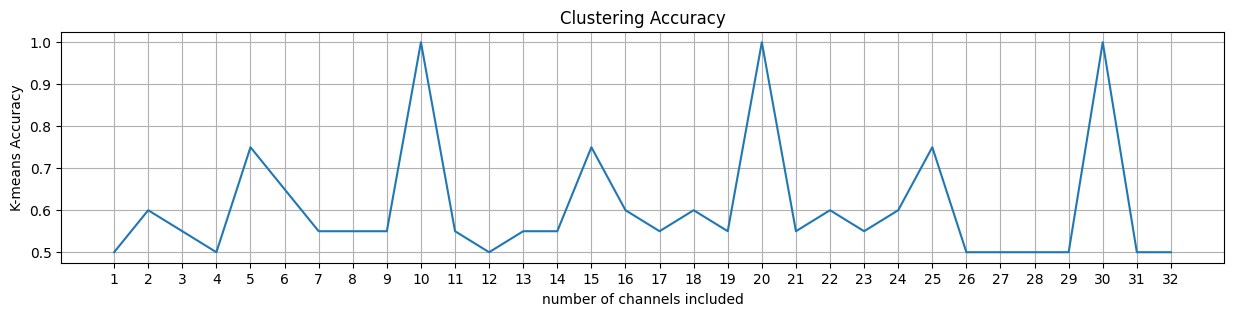

In [84]:
acc_cluster = []
for ch in range(32):
    acc = PCA_option_1(four_angle_dict, 1, 4, ch+1).to_apply_KMean()[0]
    acc_cluster.append(acc)
print(acc_cluster)

plt.figure(figsize=(15, 3)) 
plt.plot(range(1, 33), acc_cluster)
plt.xticks(range(1, 33))  # Tick every 1 unit from 1 to 32
plt.xlabel('number of channels included')
plt.ylabel('K-means Accuracy')
plt.title('Clustering Accuracy')
plt.grid(True)
plt.show()    

 <span style="font-family:'Times New Roman';">

### Option 2 

 <span style="font-family:'Times New Roman';">

#### Explore channel-level structure 


input -> (n channels, m features)


1️⃣ 1 Channel per Signal
Only two dots → limited information

PCA not meaningful due to lack of variation

Not useful unless the signal differences are very large

2️⃣ 10 Channels per Signal
Good separation appears between blue (Signal 1) and orange (Signal 4)

You can see divergence in PC1 and PC3

Still interpretable, especially for compact spatial representations

3️⃣ 20 Channels per Signal
Much clearer clustering by condition

More channels → better structure across principal components

This looks visually strong, with clean separation in 3D

4️⃣ 32 Channels per Signal
Still good separation, but clusters are more intermingled

Possible cause: extra noisy or redundant channels dilute variance explained by PC1–PC3

But still a decent result, especially if generalization across all channels is the goal
<br><br>


| Channels Used | PCA Usefulness              | Notes                          |
|---------------|-----------------------------|--------------------------------|
| 1             | ❌ Not enough data           |  Just 2 samples – not meaningful|
| 10            | ✅ Good separation visible  | Compact and efficient          |
| 20            | ✅✅ Very clear differences | Best balance so far            |
| 32            | ✅ May get noisy           | Use if signal quality is high  |
    
   <br><br><br>


(1, 6103)
(1, 6103)
(2, 6103)
(2, 2)
(1, 2)
(1, 2)


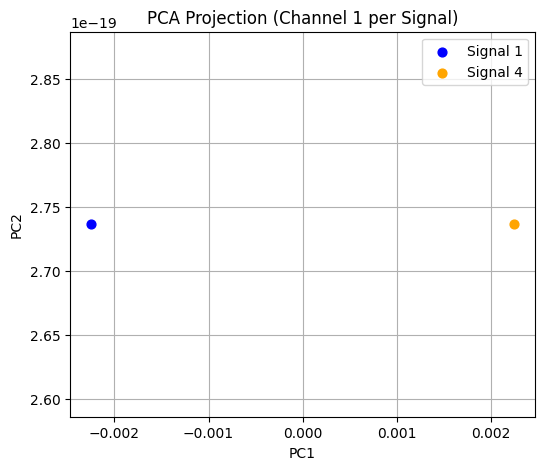

In [75]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


mean_signal_sample = Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).get_grand_mean_signal()[1]

# Angle 1 on channel 1

signal_1 = np.array([mean_signal_sample[1][0]])

print(signal_1.shape)

# angle 4 on channel 1

signal_4 = np.array([mean_signal_sample[4][0]])

print(signal_4.shape)
    


# Fit PCA on combined data (recommended)
X_combined = np.vstack([signal_1, signal_4])
print(X_combined.shape)
pca = PCA(n_components=2)
X_combined_reduced = pca.fit_transform(X_combined)

print(X_combined_reduced.shape)


# Split back
X1_reduced = X_combined_reduced[:1]
X4_reduced = X_combined_reduced[1:]

print(X1_reduced.shape)
print(X4_reduced.shape)

plt.figure(figsize=(6, 5))

# Plot Signal 1
plt.scatter(X1_reduced[:, 0], X1_reduced[:, 1], color='blue', label='Signal 1', s=40)

# Plot Signal 4
plt.scatter(X4_reduced[:, 0], X4_reduced[:, 1], color='orange', label='Signal 4', s=40)

# Labels and title
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('PCA Projection (Channel 1 per Signal)')
plt.legend()
plt.grid(True)
plt.show()

32
<class 'list'>
<class 'numpy.ndarray'>
(6103,)
6103
(10, 6103)
6103
(10, 6103)
(20, 6103)
(20, 3)
(10, 3)
(10, 3)


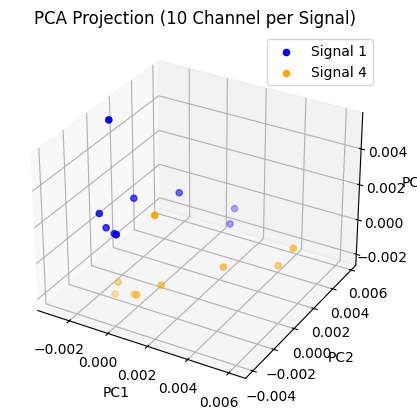

In [57]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


mean_signal_sample = Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).get_grand_mean_signal()[1]

print(len(mean_signal_sample[1]))
print(type(mean_signal_sample[1])) 

print(type(mean_signal_sample[1][0]))
print(mean_signal_sample[1][0].shape)


# Angle 1 on channel 1-10
min_length = min(mean_signal_sample[1][i].shape[0] for i in range(10))
print(min_length)
signal_1 = np.array([mean_signal_sample[1][i][:min_length] for i in range(10)])
#signal_1 = signal_1.reshape(10, -1)
print(signal_1.shape)

# angle 4 on channel 1-10
min_length = min(mean_signal_sample[4][i].shape[0] for i in range(10))
print(min_length)
signal_4 = np.array([mean_signal_sample[4][i][:min_length] for i in range(10)])

#signal_4 = signal_4.reshape(10, -1)

#print(signal_4)
print(signal_4.shape)
    
# X1 = signal_1.T
# print(X1.shape) 
# X4 = signal_4.T    
# print(X4.shape) 

# Fit PCA on combined data (recommended)
X_combined = np.vstack([signal_1, signal_4])
print(X_combined.shape)
pca = PCA(n_components=3)
X_combined_reduced = pca.fit_transform(X_combined)

print(X_combined_reduced.shape)


# Split back
X1_reduced = X_combined_reduced[:10]
X4_reduced = X_combined_reduced[10:]

print(X1_reduced.shape)
print(X4_reduced.shape)

# 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*X1_reduced.T, color='blue', label='Signal 1', s=20)
ax.scatter(*X4_reduced.T, color='orange', label='Signal 4', s=20)

ax.set_title("PCA Projection (10 Channels per Signal)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()

32
<class 'list'>
<class 'numpy.ndarray'>
(6103,)
6103
(20, 6103)
6103
(20, 6103)
(40, 6103)
(40, 3)
(20, 3)
(20, 3)


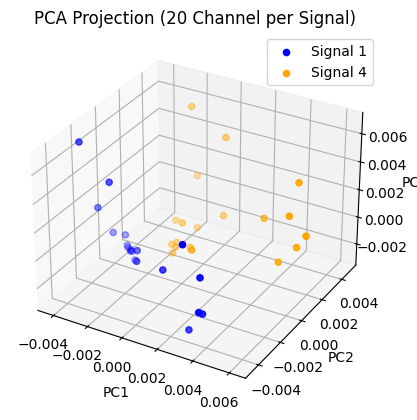

In [59]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


mean_signal_sample = Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).get_grand_mean_signal()[1]

print(len(mean_signal_sample[1]))
print(type(mean_signal_sample[1])) 

print(type(mean_signal_sample[1][0]))
print(mean_signal_sample[1][0].shape)


# Angle 1 on channel 1-20
min_length = min(mean_signal_sample[1][i].shape[0] for i in range(20))
print(min_length)
signal_1 = np.array([mean_signal_sample[1][i][:min_length] for i in range(20)])
#signal_1 = signal_1.reshape(10, -1)
print(signal_1.shape)

# angle 4 on channel 1-20
min_length = min(mean_signal_sample[4][i].shape[0] for i in range(20))
print(min_length)
signal_4 = np.array([mean_signal_sample[4][i][:min_length] for i in range(20)])

#signal_4 = signal_4.reshape(10, -1)

#print(signal_4)
print(signal_4.shape)
    
# X1 = signal_1.T
# print(X1.shape) 
# X4 = signal_4.T    
# print(X4.shape) 

# Fit PCA on combined data (recommended)
X_combined = np.vstack([signal_1, signal_4])
print(X_combined.shape)
pca = PCA(n_components=3)
X_combined_reduced = pca.fit_transform(X_combined)

print(X_combined_reduced.shape)


# Split back
X1_reduced = X_combined_reduced[:20]
X4_reduced = X_combined_reduced[20:]

print(X1_reduced.shape)
print(X4_reduced.shape)

# 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*X1_reduced.T, color='blue', label='Signal 1', s=20)
ax.scatter(*X4_reduced.T, color='orange', label='Signal 4', s=20)

ax.set_title("PCA Projection (20 Channels per Signal)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()

32
<class 'list'>
<class 'numpy.ndarray'>
(6103,)
6103
(32, 6103)
6103
(32, 6103)
(64, 6103)
(64, 3)
(32, 3)
(32, 3)


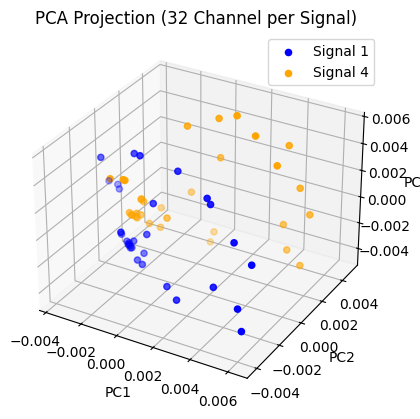

In [60]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


mean_signal_sample = Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).get_grand_mean_signal()[1]

print(len(mean_signal_sample[1]))
print(type(mean_signal_sample[1])) 

print(type(mean_signal_sample[1][0]))
print(mean_signal_sample[1][0].shape)


# Angle 1 on channel 1-32
min_length = min(mean_signal_sample[1][i].shape[0] for i in range(32))
print(min_length)
signal_1 = np.array([mean_signal_sample[1][i][:min_length] for i in range(32)])
#signal_1 = signal_1.reshape(10, -1)
print(signal_1.shape)

# angle 4 on channel 1-32
min_length = min(mean_signal_sample[4][i].shape[0] for i in range(32))
print(min_length)
signal_4 = np.array([mean_signal_sample[4][i][:min_length] for i in range(32)])

#signal_4 = signal_4.reshape(10, -1)

#print(signal_4)
print(signal_4.shape)
    
# X1 = signal_1.T
# print(X1.shape) 
# X4 = signal_4.T    
# print(X4.shape) 

# Fit PCA on combined data (recommended)
X_combined = np.vstack([signal_1, signal_4])
print(X_combined.shape)
pca = PCA(n_components=3)
X_combined_reduced = pca.fit_transform(X_combined)

print(X_combined_reduced.shape)


# Split back
X1_reduced = X_combined_reduced[:32]
X4_reduced = X_combined_reduced[32:]

print(X1_reduced.shape)
print(X4_reduced.shape)

# 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*X1_reduced.T, color='blue', label='Signal 1', s=20)
ax.scatter(*X4_reduced.T, color='orange', label='Signal 4', s=20)

ax.set_title("PCA Projection (32 Channels per Signal)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()